In [9]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [10, 7]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
import glob
import astropy.io.votable as votable
from PyAstronomy.pyasl import crosscorrRV, quadExtreme
%matplotlib inline
import pwlf

In [10]:
table = Table.read('filetable.fits')

In [11]:
table

white_dwarf_name_1,designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,astrometric_sigma5d_max,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,l,b,density,AG,SDSS_name_1,umag_1,e_umag_1,gmag_1,e_gmag_1,rmag_1,e_rmag_1,imag_1,e_imag_1,zmag_1,e_zmag_1,test_Pwd,Pwd_flag,Teff,eTeff,log_g,elog_g,mass,emass,chi2,Teff_He,eTeff_He,log_g_He,elog_g_He,mass_He,emass_He,chisq_He,white_dwarf_name_2,SDSS_name_2,SDSS_ra,SDSS_dec,umag_2,e_umag_2,gmag_2,e_gmag_2,rmag_2,e_rmag_2,imag_2,e_imag_2,zmag_2,e_zmag_2,Plate,mjd,fiberID,S/N,spectral_class,specpath
bytes23,bytes28,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes23,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,bytes10,bytes70
WDJ025854.43+003040.34,Gaia DR2 74698071455360,74698071455360,44.72646901556998,0.28567386112959603,0.5112707464812695,0.25599366159026676,14.500739904268581,0.36579731793162606,-78.52656079709863,0.5427489490094788,15.012084874836075,0.5470492489368379,0.0,0.5372557,534.3824372487403,1.8082009054878507,18.868734,312.15862412335844,18.40885445099136,19.11545,362.21514538571427,11.172177243298819,18.364504,1.2619685,176.11511398045826,-48.74189973283115,2772.1445,0.17931461323760367,J025854.44+003040.3,19.962,0.033,19.174,0.01,18.833,0.01,18.694,0.013,18.661,0.04,0.988624,0,5912.964868,303.260477,8.372084,0.167457,0.827522,0.111186,1.319487,5759.198239,311.522807,8.282587,0.185514,0.752814,0.123687,1.221527,WDJ025854.43+003040.34,J025854.44+003040.3,44.726785,0.51121322,19.962,0.033,19.174,0.01,18.833,0.01,18.694,0.013,18.661,0.04,3184,54850,476,22.13875775,DA,../scratch/spec/spectra_batch_006/74698071455360_spec_2.fits
WDJ030342.24+005310.43,Gaia DR2 152935195517952,152935195517952,45.92584768471102,0.18368731112639675,0.8861145695998326,0.2010294471025037,4.671757153169625,0.3331957274737135,-30.908062217688194,0.3572135974662655,-26.73967510017829,0.34644328777017175,0.27127564966991097,0.43184733,1177.987020866133,2.9259743881980267,18.010515,878.0295268386217,9.245145660546411,17.992615,489.7343926137647,7.6349728756875725,18.037018,1.1611027,176.96708518810607,-47.62112094935022,2448.3142,0.1866174361585069,J030342.22+005310.3,18.287,0.015,17.879,0.006,18.117,0.007,18.35,0.011,18.611,0.039,0.999324,0,13259.833096,649.629009,7.786484,0.154615,0.493008,0.069604,0.007033,12730.785698,538.47192,7.745324,0.14715,0.473115,0.049265,10.165591,WDJ030342.24+005310.43,J030342.22+005310.3,45.925915,0.88615422,18.287,0.015,17.879,0.006,18.117,0.007,18.35,0.011,18.611,0.039,7255,56597,541,37.07371632,DA,../scratch/spec/spectra_batch_002/152935195517952_spec_2.fits
WDJ030451.07+010644.99,Gaia DR2 185954904271872,185954904271872,46.212790997041324,0.5160441824748764,1.1124797793563967,0.5408620242643588,0.9023387726781019,0.6681183968825999,1.2395325533553607,1.0945712074894716,-3.8588736577358373,1.0264476122799477,0.0,1.0174972,202.12171815590497,1.6276458955658366,19.924334,126.50702819483377,10.634988238286617,20.096102,107.24490792917832,10.180014395408431,19.685978,1.1564909,177.01995172650172,-47.25742609153092,3312.5933,0.17410005440944148,J030451.06+010644.9,21.071,0.083,19.971,0.017,19.927,0.02,20.03,0.032,19.942,0.113,0.304529,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,WDJ030451.07+010644.99,J030451.06+010644.9,46.212773,1.1125,21.071,0.083,19.971,0.017,19.927,0.02,2

## Classification Cuts - White Dwarfs, Main Sequence, Uncertain Region

#### Define Spectrum Processing Functions

In [12]:
spec_files = glob.glob('ks_spec/*')
lamgrid = np.arange(4000,8000)

def planck(wl,c1,c2):
    return 1e21*c1 / (wl**5 * (np.exp(1e4*c2/wl) - 1 ))

def planck(wl, c1, c2):
    return c1*wl + c2

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_raw_spectrum(source_id):
    path = table[table['source_id'] == source_id][0]['specpath']
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        raise OSError('Spectrum file missing...')
    
    return lam,flux#,fluxsig


def continuum_normalize(flux,lam,sigarray = None):
    spec = flux
    pixels = lam-4000
    continuum = (pixels > 2900) + (pixels < 2200)*(pixels > 1050) + (pixels < 650)*(pixels > 530) \
             + (pixels < 220)*(pixels > 200) + (pixels < 35)*(pixels > 20) + (pixels < -200)*(pixels > -450)
    
    notnan = (~np.isnan(spec))+(~np.isnan(lam))
    skylinemask = (lam > 5578.5 - 10)*(lam < 5578.5 + 10) + (lam > 5894.6 - 10)*(lam < 5894.6 + 10)\
        + (lam > 6301.7 - 10)*(lam < 6301.7 + 10) + (lam > 7246.0 - 10)*(lam < 7246.0 + 10)
        
    pwfunc = pwlf.PiecewiseLinFit(lam[continuum*notnan],spec[continuum*notnan])
    breakpoints = np.asarray([-350,-200,20,35,200,220,400,530,650,850,1050,1400,1800,2200,2900,3200,3400,3800]) + 4000
    breaks = pwfunc.fit_with_breaks(breakpoints)
    cont = pwfunc.predict(lam)
    contcorr = spec / cont
    contcorr[skylinemask] = 1
    where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    contcorr[where] = 1
    if sigarray is not None:
        stdev = np.sqrt(1.0/sigarray)
        contsigarray = stdev / cont
        normivar = (1.0/contsigarray)**2
        return contcorr,normivar
    
#     plt.figure(figsize = (15,5))
#     plt.plot(lam[continuum*notnan],spec[continuum*notnan])
#     plt.plot(lam,cont)
#     plt.figure(figsize = (15,5))
#     plt.plot(contcorr)
#     plt.plot(continuum)
#     plt.figure(figsize = (15,5))
    return contcorr

def rv_corr(normflux,lam):
    alphaline = find_nearest(lam,halpha)
    betaline = find_nearest(lam,hbeta)
    gammaline = find_nearest(lam,hgamma)
    deltaline = find_nearest(lam,hdelta)
    cores = (lam == alphaline) + (lam == betaline) + (lam == gammaline) + (lam == deltaline)
    cores = cores.astype(int)
    xcorrs = crosscorrRV(lam,1-normflux,lam,cores, -100, 100, 5, 'doppler', skipedge = 25)
    corrs = xcorrs[1]
    rvs = xcorrs[0]
    try:
        specrv = quadExtreme(rvs,corrs, 'max', (10,10), fullOutput = True)[0]
    except:
        specrv = 0
    shift_flux,shift_lam = dopplerShift(lam,normflux,specrv, edgeHandling = 'fillValue', fillValue = 1)
    return shift_flux,shift_lam

def interpolate_flux(normflux,lam):
    func = interp1d(lam,normflux,kind='linear',assume_sorted = True)
    interpflux = func(lamgrid)
    return interpflux

def get_spectrum(source_id):
    path = table[table['source_id'] == source_id][0]['specpath']
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        raise FileNotFoundError('Spectrum file missing...')
        return
    ## RV Correction and Interpolation
    
    normalized_spectrum = continuum_normalize(flux,lam)
    rv_corrected_flux,rv_corrected_lam = rv_corr(normalized_spectrum,lam)
    interpolated_flux = interpolate_flux(rv_corrected_flux, rv_corrected_lam)
    
    return interpolated_flux

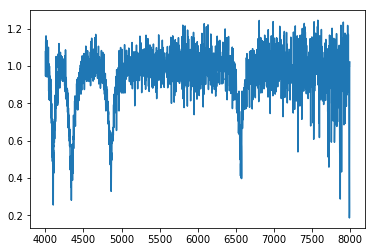

In [13]:
plt.plot(lamgrid,get_spectrum(table['source_id'][7543]))

## Build Dataset

##### For this demonstration, we are training a binary classifier to identify DA white dwarf spectra that are 1) identified as DA by Kepler AND 2) belong in the high-confidence white dwarf section of our color magnitude diagram. During the training step, the model is fed both high-confidence sdA's and high-confidence DA's - where Kepler's labels agree with our visual expectation from the CMD. Later on, we will apply this classifier to stars in the uncertain strip between the main sequence and white dwarf tracks. 

In [14]:
filetable = table

DA = filetable['spectral_class'] == 'DA'
filetable = filetable[DA]
len(filetable)

15491

In [15]:
spectra = [];
for jj in tqdm(range(len(filetable))):
    obj = filetable[jj]
    try:
        spec = get_spectrum(obj['source_id'])
        spectra.append(spec)
    except:
        spectra.append(np.repeat(np.nan,4000))

100%|██████████| 15491/15491 [10:17<00:00, 25.08it/s]


In [16]:
spectra = np.asarray(spectra)
len(spectra)
cleanspec = ~np.max(np.isnan(spectra),1)
cleantable = filetable[cleanspec]
cleanspectra = spectra[cleanspec]

In [17]:
def make_binary(spectrum1, spectrum2, relrv, relfraction):
    spectrum2 = dopplerShift(lamgrid,spectrum2,relrv, edgeHandling = 'fillValue', fillValue = 1)
    func = interp1d(spectrum2[1],spectrum2[0], fill_value = 'extrapolate', kind = 'linear')
    spectrum2 = func(lamgrid)
    binary = relfraction*spectrum1 + (1-relfraction)*spectrum2
    return binary

Text(0.5, 1.0, 'Composite Binary')

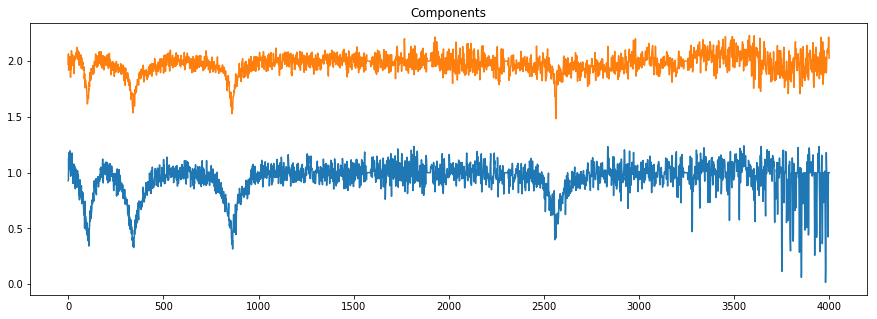

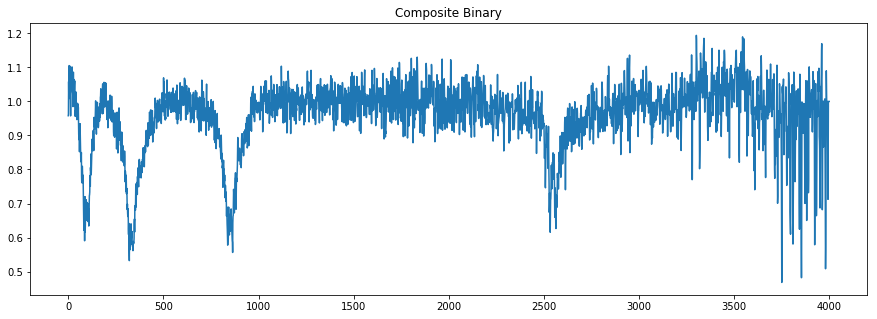

In [18]:
ii = np.random.randint(len(cleantable))
jj = np.random.randint(len(cleantable))
rv = np.random.randint(-1000,1000)
frac = 0.5

plt.figure(figsize = (15,5))
plt.title('Components')
plt.plot(cleanspectra[ii])
plt.plot(cleanspectra[jj]+1)

plt.figure(figsize = (15,5))
plt.plot(make_binary(cleanspectra[ii],cleanspectra[jj],rv,frac))
plt.title('Composite Binary')

In [19]:
def generate_random_binary():
    ii = np.random.randint(0, len(cleanspectra))
    jj = np.random.randint(0, len(cleanspectra))
    rv = np.random.randint(-1000,1000) ### Parameterize this with actual RV distribution
    frac = np.random.random()
    return make_binary(cleanspectra[ii], cleanspectra[jj], rv, frac)
def generate_random_single():
    ii = np.random.randint(0, len(cleanspectra))
    return cleanspectra[ii]

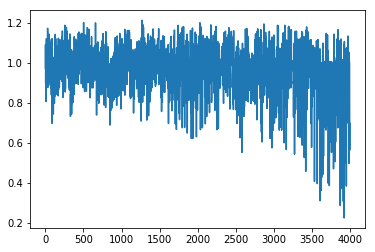

In [20]:
plt.plot(generate_random_binary())

In [21]:
def samplegen(coinflip):
    if coinflip == 0:
        return generate_random_single()
    elif coinflip == 1:
        return generate_random_binary()

In [22]:
def batchgen(batchsize):
    coinflips = np.random.binomial(1, 0.5, batchsize)
    samples = np.asarray([samplegen(coinflip) for coinflip in coinflips])
    return samples, coinflips

## Bayesian Neural Network Classifier

In [23]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler,OneHotEncoder
import astroNN.nn.layers as annlayers
import astroNN.nn.losses as annlosses
from sklearn.metrics import roc_curve, roc_auc_score, auc

Using TensorFlow backend.


In [47]:
reg = 1e-10

def nn():
    x = Input(shape=(4000,))
    y = Dense(256,activation='relu', kernel_regularizer = l2(reg))(x)
    #y = annlayers.MCDropout(0.1)(y)
    y = Dense(128,activation='relu', kernel_regularizer = l2(reg))(y)
    #y = annlayers.MCDropout(0.1)(y)
    y = Dense(64,activation='relu',kernel_regularizer = l2(reg))(y)
    #y = annlayers.MCDropout(0.1)(y)
    y = Dense(32,activation='relu',kernel_regularizer = l2(reg))(y)

    out = Dense(2,activation='softmax')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'binary_crossentropy', \
                  metrics = ['binary_accuracy'])
    return model

history = np.asarray([]);
vhistory = np.asarray([]);
model = nn()
model.load_weights('corbett.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1024256   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 1,067,554
Trainable params: 1,067,554
Non-trainable params: 0
_________________________________________________________________


Text(0, 0.5, 'Loss')

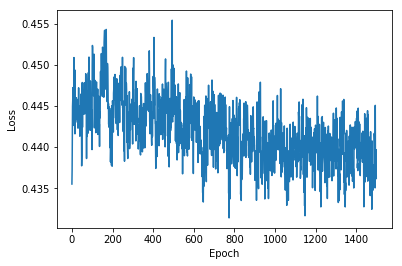

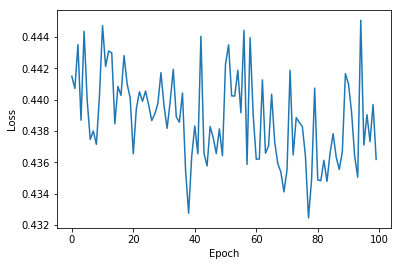

In [51]:
plt.figure()
#plt.plot(history);
plt.plot(vhistory)
plt.xlabel('Epoch')
plt.ylabel('Loss')
r = 100
plt.figure()
#plt.plot(history[-r:]);
plt.plot(vhistory[-r:]);
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [49]:
encoder = OneHotEncoder(categories = 'auto')
batchsize = 50000


for i in tqdm(range(1000)): 
    print('Training batch %i'%i)
    X_train,y_train = batchgen(batchsize)
    y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
    n_epochs = 10
    minibatchsize = 64

    print('Stochastic sample generated...')
    h = model.fit(X_train,y_train, epochs = n_epochs, verbose = 0, batch_size = minibatchsize)
    history = np.append(history, h.history['binary_accuracy'])
    vhistory = np.append(vhistory, h.history['loss'])
    model.save_weights('corbett.h5')




  0%|          | 0/1000 [00:00<?, ?it/s]

Training batch 0
Stochastic sample generated...





  0%|          | 1/1000 [02:16<37:52:59, 136.52s/it]

Training batch 1
Stochastic sample generated...





  0%|          | 2/1000 [04:29<37:35:26, 135.60s/it]

Training batch 2
Stochastic sample generated...





  0%|          | 3/1000 [06:45<37:32:54, 135.58s/it]

Training batch 3
Stochastic sample generated...





  0%|          | 4/1000 [08:57<37:14:12, 134.59s/it]

Training batch 4
Stochastic sample generated...





  0%|          | 5/1000 [11:11<37:09:17, 134.43s/it]

Training batch 5
Stochastic sample generated...





  1%|          | 6/1000 [13:20<36:39:37, 132.77s/it]

Training batch 6
Stochastic sample generated...





  1%|          | 7/1000 [15:31<36:25:09, 132.03s/it]

Training batch 7
Stochastic sample generated...





  1%|          | 8/1000 [17:41<36:15:44, 131.60s/it]

Training batch 8
Stochastic sample generated...





  1%|          | 9/1000 [19:52<36:08:25, 131.29s/it]

Training batch 9
Stochastic sample generated...





  1%|          | 10/1000 [22:04<36:12:14, 131.65s/it]

Training batch 10
Stochastic sample generated...





  1%|          | 11/1000 [24:16<36:10:50, 131.70s/it]

Training batch 11
Stochastic sample generated...





  1%|          | 12/1000 [26:27<36:03:17, 131.37s/it]

Training batch 12
Stochastic sample generated...





  1%|▏         | 13/1000 [28:38<36:03:13, 131.50s/it]

Training batch 13
Stochastic sample generated...





  1%|▏         | 14/1000 [30:53<36:13:43, 132.27s/it]

Training batch 14
Stochastic sample generated...





  2%|▏         | 15/1000 [32:59<35:44:40, 130.64s/it]

Training batch 15
Stochastic sample generated...





  2%|▏         | 16/1000 [35:09<35:39:07, 130.43s/it]

Training batch 16
Stochastic sample generated...





  2%|▏         | 17/1000 [37:24<35:57:47, 131.71s/it]

Training batch 17
Stochastic sample generated...





  2%|▏         | 18/1000 [39:35<35:51:11, 131.44s/it]

Training batch 18
Stochastic sample generated...





  2%|▏         | 19/1000 [41:43<35:30:55, 130.33s/it]

Training batch 19
Stochastic sample generated...





  2%|▏         | 20/1000 [43:53<35:27:19, 130.24s/it]

Training batch 20
Stochastic sample generated...





  2%|▏         | 21/1000 [46:02<35:23:35, 130.15s/it]

Training batch 21
Stochastic sample generated...





  2%|▏         | 22/1000 [48:14<35:28:17, 130.57s/it]

Training batch 22
Stochastic sample generated...





  2%|▏         | 23/1000 [50:23<35:18:18, 130.09s/it]

Training batch 23
Stochastic sample generated...





  2%|▏         | 24/1000 [52:33<35:16:52, 130.14s/it]

Training batch 24
Stochastic sample generated...





  2%|▎         | 25/1000 [54:45<35:20:40, 130.50s/it]

Training batch 25
Stochastic sample generated...





  3%|▎         | 26/1000 [56:57<35:26:35, 131.00s/it]

Training batch 26
Stochastic sample generated...





  3%|▎         | 27/1000 [59:08<35:23:09, 130.92s/it]

Training batch 27
Stochastic sample generated...





  3%|▎         | 28/1000 [1:01:19<35:21:25, 130.95s/it]

Training batch 28
Stochastic sample generated...





  3%|▎         | 29/1000 [1:03:29<35:18:46, 130.92s/it]

Training batch 29
Stochastic sample generated...





  3%|▎         | 30/1000 [1:05:40<35:16:51, 130.94s/it]

Training batch 30
Stochastic sample generated...





  3%|▎         | 31/1000 [1:07:52<35:19:13, 131.22s/it]

Training batch 31
Stochastic sample generated...





  3%|▎         | 32/1000 [1:10:05<35:22:36, 131.57s/it]

Training batch 32
Stochastic sample generated...





  3%|▎         | 33/1000 [1:12:14<35:10:08, 130.93s/it]

Training batch 33
Stochastic sample generated...





  3%|▎         | 34/1000 [1:14:25<35:09:07, 131.00s/it]

Training batch 34
Stochastic sample generated...





  4%|▎         | 35/1000 [1:16:37<35:12:39, 131.36s/it]

Training batch 35
Stochastic sample generated...





  4%|▎         | 36/1000 [1:18:49<35:10:23, 131.35s/it]

Training batch 36
Stochastic sample generated...





  4%|▎         | 37/1000 [1:21:02<35:18:39, 132.00s/it]

Training batch 37
Stochastic sample generated...





  4%|▍         | 38/1000 [1:23:15<35:21:04, 132.29s/it]

Training batch 38
Stochastic sample generated...





  4%|▍         | 39/1000 [1:25:28<35:21:19, 132.44s/it]

Training batch 39
Stochastic sample generated...





  4%|▍         | 40/1000 [1:27:40<35:17:41, 132.36s/it]

Training batch 40
Stochastic sample generated...





  4%|▍         | 41/1000 [1:29:49<34:58:34, 131.30s/it]

Training batch 41
Stochastic sample generated...





  4%|▍         | 42/1000 [1:32:00<34:57:01, 131.34s/it]

Training batch 42
Stochastic sample generated...





  4%|▍         | 43/1000 [1:34:14<35:04:06, 131.92s/it]

Training batch 43
Stochastic sample generated...





  4%|▍         | 44/1000 [1:36:26<35:03:38, 132.03s/it]

Training batch 44
Stochastic sample generated...





  4%|▍         | 45/1000 [1:38:37<34:56:37, 131.73s/it]

Training batch 45
Stochastic sample generated...





  5%|▍         | 46/1000 [1:40:49<34:54:15, 131.71s/it]

Training batch 46
Stochastic sample generated...





  5%|▍         | 47/1000 [1:43:01<34:52:45, 131.76s/it]

Training batch 47
Stochastic sample generated...





  5%|▍         | 48/1000 [1:45:13<34:51:52, 131.84s/it]

Training batch 48
Stochastic sample generated...





  5%|▍         | 49/1000 [1:47:21<34:33:58, 130.85s/it]

Training batch 49
Stochastic sample generated...





  5%|▌         | 50/1000 [1:49:30<34:21:18, 130.19s/it]

Training batch 50
Stochastic sample generated...





  5%|▌         | 51/1000 [1:51:41<34:25:34, 130.59s/it]

Training batch 51
Stochastic sample generated...





  5%|▌         | 52/1000 [1:53:53<34:26:09, 130.77s/it]

Training batch 52
Stochastic sample generated...





  5%|▌         | 53/1000 [1:56:04<34:26:14, 130.91s/it]

Training batch 53
Stochastic sample generated...





  5%|▌         | 54/1000 [1:58:15<34:26:23, 131.06s/it]

Training batch 54
Stochastic sample generated...





  6%|▌         | 55/1000 [2:00:27<34:26:19, 131.20s/it]

Training batch 55
Stochastic sample generated...





  6%|▌         | 56/1000 [2:02:39<34:28:15, 131.46s/it]

Training batch 56
Stochastic sample generated...





  6%|▌         | 57/1000 [2:04:50<34:26:35, 131.49s/it]

Training batch 57
Stochastic sample generated...





  6%|▌         | 58/1000 [2:07:06<34:43:50, 132.73s/it]

Training batch 58
Stochastic sample generated...





  6%|▌         | 59/1000 [2:09:21<34:50:13, 133.28s/it]

Training batch 59
Stochastic sample generated...





  6%|▌         | 60/1000 [2:11:33<34:46:20, 133.17s/it]

Training batch 60
Stochastic sample generated...





  6%|▌         | 61/1000 [2:13:45<34:34:31, 132.56s/it]

Training batch 61
Stochastic sample generated...





  6%|▌         | 62/1000 [2:15:57<34:32:20, 132.56s/it]

Training batch 62
Stochastic sample generated...





  6%|▋         | 63/1000 [2:18:09<34:29:08, 132.50s/it]

Training batch 63
Stochastic sample generated...





  6%|▋         | 64/1000 [2:20:19<34:15:05, 131.74s/it]

Training batch 64
Stochastic sample generated...





  6%|▋         | 65/1000 [2:22:31<34:13:44, 131.79s/it]

Training batch 65
Stochastic sample generated...





  7%|▋         | 66/1000 [2:24:44<34:13:51, 131.94s/it]

Training batch 66
Stochastic sample generated...





  7%|▋         | 67/1000 [2:26:56<34:14:15, 132.11s/it]

Training batch 67
Stochastic sample generated...





  7%|▋         | 68/1000 [2:29:11<34:25:45, 132.99s/it]

Training batch 68
Stochastic sample generated...





  7%|▋         | 69/1000 [2:31:25<34:25:34, 133.12s/it]

Training batch 69
Stochastic sample generated...





  7%|▋         | 70/1000 [2:33:33<33:59:10, 131.56s/it]

Training batch 70
Stochastic sample generated...





  7%|▋         | 71/1000 [2:35:43<33:53:41, 131.35s/it]

Training batch 71
Stochastic sample generated...





  7%|▋         | 72/1000 [2:37:53<33:41:52, 130.72s/it]

Training batch 72
Stochastic sample generated...





  7%|▋         | 73/1000 [2:40:04<33:41:55, 130.87s/it]

Training batch 73
Stochastic sample generated...





  7%|▋         | 74/1000 [2:42:15<33:41:50, 131.00s/it]

Training batch 74
Stochastic sample generated...





  8%|▊         | 75/1000 [2:44:27<33:44:39, 131.33s/it]

Training batch 75
Stochastic sample generated...





  8%|▊         | 76/1000 [2:46:42<33:58:06, 132.34s/it]

Training batch 76
Stochastic sample generated...





  8%|▊         | 77/1000 [2:48:52<33:45:29, 131.67s/it]

Training batch 77
Stochastic sample generated...





  8%|▊         | 78/1000 [2:51:04<33:46:00, 131.84s/it]

Training batch 78
Stochastic sample generated...





  8%|▊         | 79/1000 [2:53:15<33:37:33, 131.44s/it]

Training batch 79
Stochastic sample generated...





  8%|▊         | 80/1000 [2:55:26<33:33:06, 131.29s/it]

Training batch 80
Stochastic sample generated...





  8%|▊         | 81/1000 [2:57:36<33:27:56, 131.10s/it]

Training batch 81
Stochastic sample generated...





  8%|▊         | 82/1000 [2:59:45<33:16:10, 130.47s/it]

Training batch 82
Stochastic sample generated...





  8%|▊         | 83/1000 [5:38:06<749:16:38, 2941.55s/it]

Training batch 83
Stochastic sample generated...





  8%|▊         | 84/1000 [6:38:59<802:43:21, 3154.80s/it]

Training batch 84
Stochastic sample generated...





  8%|▊         | 85/1000 [7:35:36<820:20:02, 3227.54s/it]

Training batch 85
Stochastic sample generated...





  9%|▊         | 86/1000 [7:55:38<665:11:48, 2620.03s/it]

Training batch 86
Stochastic sample generated...





  9%|▊         | 87/1000 [8:47:25<701:31:51, 2766.17s/it]

Training batch 87
Stochastic sample generated...





  9%|▉         | 88/1000 [9:08:20<585:54:56, 2312.82s/it]

Training batch 88
Stochastic sample generated...





  9%|▉         | 89/1000 [9:10:32<419:39:00, 1658.33s/it]

Training batch 89
Stochastic sample generated...





  9%|▉         | 90/1000 [9:12:40<303:08:11, 1199.22s/it]

Training batch 90
Stochastic sample generated...





  9%|▉         | 91/1000 [9:14:51<221:55:02, 878.88s/it] 

Training batch 91
Stochastic sample generated...





  9%|▉         | 92/1000 [9:17:01<164:58:24, 654.08s/it]

Training batch 92
Stochastic sample generated...





  9%|▉         | 93/1000 [9:19:12<125:15:52, 497.19s/it]

Training batch 93
Stochastic sample generated...





  9%|▉         | 94/1000 [9:21:24<97:33:44, 387.67s/it] 

Training batch 94
Stochastic sample generated...





 10%|▉         | 95/1000 [9:23:38<78:19:40, 311.58s/it]

Training batch 95
Stochastic sample generated...





 10%|▉         | 96/1000 [9:25:52<64:54:06, 258.46s/it]

Training batch 96
Stochastic sample generated...





 10%|▉         | 97/1000 [9:28:05<55:20:00, 220.60s/it]

Training batch 97
Stochastic sample generated...





 10%|▉         | 98/1000 [9:30:19<48:47:10, 194.71s/it]

Training batch 98
Stochastic sample generated...





 10%|▉         | 99/1000 [9:32:32<44:07:15, 176.29s/it]

Training batch 99
Stochastic sample generated...





 10%|█         | 100/1000 [9:34:45<40:50:36, 163.37s/it]

Training batch 100
Stochastic sample generated...





 10%|█         | 101/1000 [9:36:58<38:30:58, 154.24s/it]

Training batch 101
Stochastic sample generated...





 10%|█         | 102/1000 [9:39:12<36:55:35, 148.04s/it]

Training batch 102
Stochastic sample generated...





 10%|█         | 103/1000 [9:41:23<35:38:52, 143.07s/it]

Training batch 103
Stochastic sample generated...





 10%|█         | 104/1000 [9:43:37<34:54:02, 140.23s/it]

Training batch 104
Stochastic sample generated...





 10%|█         | 105/1000 [9:45:47<34:04:42, 137.08s/it]

Training batch 105
Stochastic sample generated...





 11%|█         | 106/1000 [9:48:01<33:48:30, 136.14s/it]

Training batch 106
Stochastic sample generated...





 11%|█         | 107/1000 [9:50:14<33:34:27, 135.35s/it]

Training batch 107
Stochastic sample generated...





 11%|█         | 108/1000 [9:52:26<33:17:58, 134.39s/it]

Training batch 108
Stochastic sample generated...





 11%|█         | 109/1000 [9:54:41<33:16:55, 134.47s/it]

Training batch 109
Stochastic sample generated...





 11%|█         | 110/1000 [9:56:56<33:15:17, 134.51s/it]

Training batch 110
Stochastic sample generated...





 11%|█         | 111/1000 [9:59:08<33:03:17, 133.86s/it]

Training batch 111
Stochastic sample generated...





 11%|█         | 112/1000 [10:01:23<33:04:56, 134.12s/it]

Training batch 112
Stochastic sample generated...





 11%|█▏        | 113/1000 [10:03:36<32:58:32, 133.84s/it]

Training batch 113
Stochastic sample generated...





 11%|█▏        | 114/1000 [10:05:50<32:55:22, 133.77s/it]

Training batch 114
Stochastic sample generated...





 12%|█▏        | 115/1000 [10:08:05<33:01:49, 134.36s/it]

Training batch 115
Stochastic sample generated...





 12%|█▏        | 116/1000 [10:10:21<33:04:59, 134.73s/it]

Training batch 116
Stochastic sample generated...





 12%|█▏        | 117/1000 [10:12:35<32:59:12, 134.49s/it]

Training batch 117
Stochastic sample generated...





 12%|█▏        | 118/1000 [10:14:47<32:46:16, 133.76s/it]

Training batch 118
Stochastic sample generated...





 12%|█▏        | 119/1000 [10:17:01<32:46:08, 133.90s/it]

Training batch 119
Stochastic sample generated...





 12%|█▏        | 120/1000 [10:19:15<32:45:03, 133.98s/it]

Training batch 120
Stochastic sample generated...





 12%|█▏        | 121/1000 [10:21:28<32:37:20, 133.61s/it]

Training batch 121
Stochastic sample generated...





 12%|█▏        | 122/1000 [10:23:40<32:26:17, 133.00s/it]

Training batch 122
Stochastic sample generated...





 12%|█▏        | 123/1000 [10:25:56<32:38:17, 133.98s/it]

Training batch 123
Stochastic sample generated...





 12%|█▏        | 124/1000 [10:28:08<32:28:59, 133.49s/it]

Training batch 124
Stochastic sample generated...





 12%|█▎        | 125/1000 [10:30:22<32:28:33, 133.62s/it]

Training batch 125
Stochastic sample generated...





 13%|█▎        | 126/1000 [10:32:35<32:23:21, 133.41s/it]

Training batch 126
Stochastic sample generated...





 13%|█▎        | 127/1000 [10:34:47<32:13:14, 132.87s/it]

Training batch 127
Stochastic sample generated...





 13%|█▎        | 128/1000 [10:37:00<32:15:04, 133.15s/it]

Training batch 128
Stochastic sample generated...





 13%|█▎        | 129/1000 [10:39:14<32:14:47, 133.28s/it]

Training batch 129
Stochastic sample generated...





 13%|█▎        | 130/1000 [10:41:27<32:12:43, 133.29s/it]

Training batch 130
Stochastic sample generated...





 13%|█▎        | 131/1000 [10:43:41<32:13:19, 133.49s/it]

Training batch 131
Stochastic sample generated...





 13%|█▎        | 132/1000 [10:45:55<32:10:44, 133.46s/it]

Training batch 132
Stochastic sample generated...





 13%|█▎        | 133/1000 [10:48:08<32:06:12, 133.30s/it]

Training batch 133
Stochastic sample generated...





 13%|█▎        | 134/1000 [10:50:20<32:00:38, 133.07s/it]

Training batch 134
Stochastic sample generated...





 14%|█▎        | 135/1000 [10:52:35<32:04:57, 133.52s/it]

Training batch 135
Stochastic sample generated...





 14%|█▎        | 136/1000 [10:54:48<31:59:45, 133.32s/it]

Training batch 136
Stochastic sample generated...





 14%|█▎        | 137/1000 [10:57:00<31:54:59, 133.14s/it]

Training batch 137
Stochastic sample generated...





 14%|█▍        | 138/1000 [10:59:15<31:59:21, 133.60s/it]

Training batch 138
Stochastic sample generated...





 14%|█▍        | 139/1000 [11:01:30<32:01:53, 133.93s/it]

Training batch 139
Stochastic sample generated...





 14%|█▍        | 140/1000 [11:03:41<31:49:36, 133.23s/it]

Training batch 140
Stochastic sample generated...





 14%|█▍        | 141/1000 [11:05:56<31:55:23, 133.79s/it]

Training batch 141
Stochastic sample generated...





 14%|█▍        | 142/1000 [11:08:12<31:59:18, 134.22s/it]

Training batch 142
Stochastic sample generated...





 14%|█▍        | 143/1000 [11:10:27<32:01:04, 134.50s/it]

Training batch 143
Stochastic sample generated...





 14%|█▍        | 144/1000 [11:12:42<32:03:37, 134.83s/it]

Training batch 144
Stochastic sample generated...





 14%|█▍        | 145/1000 [11:14:57<31:59:14, 134.68s/it]

Training batch 145
Stochastic sample generated...





 15%|█▍        | 146/1000 [11:17:09<31:47:06, 133.99s/it]

Training batch 146
Stochastic sample generated...





 15%|█▍        | 147/1000 [11:19:28<32:08:04, 135.62s/it]

Training batch 147
Stochastic sample generated...





 15%|█▍        | 148/1000 [11:22:01<33:17:32, 140.67s/it]

Training batch 148
Stochastic sample generated...





 15%|█▍        | 149/1000 [11:24:54<35:34:49, 150.52s/it]

Training batch 149
Stochastic sample generated...





 15%|█▌        | 150/1000 [11:27:41<36:42:15, 155.45s/it]

Training batch 150
Stochastic sample generated...


KeyboardInterrupt: 

Thresholded Accuracy on validation dataset: 77.98 percent
MLE Classification Accuracy on validation dataset: 77.98 percent


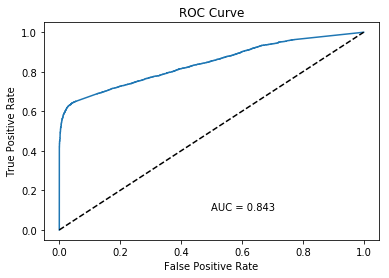

In [53]:
X_test,y_test = batchgen(10000)
y_test = encoder.transform(y_test.reshape(-1,1)).toarray()


pred_proba = model.predict(X_test)
preds = pred_proba[:,1] > pred_proba[:,0]

fpr,tpr,_ = roc_curve(y_test[:,1],pred_proba[:,1])

plt.plot(fpr,tpr)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.title('ROC Curve')
plt.text(0.5,0.1,'AUC = %.3f'%auc(fpr,tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print("Thresholded Accuracy on validation dataset: %.2f percent"%(sum(preds == y_test[:,1])/len(y_test)*100));

choice_class = model.predict(X_test)[:,1] > model.predict(X_test)[:,0]
print("MLE Classification Accuracy on validation dataset: %.2f percent"\
      %(sum(choice_class == y_test[:,1])/len(y_test)*100));

# Apply to Actual Dataset

In [54]:
bin_prob = model.predict(cleanspectra)

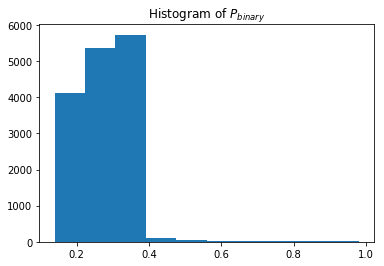

In [55]:
plt.hist(bin_prob[:,1])
plt.title('Histogram of $P_{binary}$');

In [61]:
threshold = 0.90

In [62]:
binaries = bin_prob[:,1] > threshold

In [63]:
cleantable['bin_prob'] = bin_prob[:,1]

In [64]:
sum(binaries)

33

36321786805002880
Probability of Binarity = 0.95
55.809874130452684 10.49392921799668


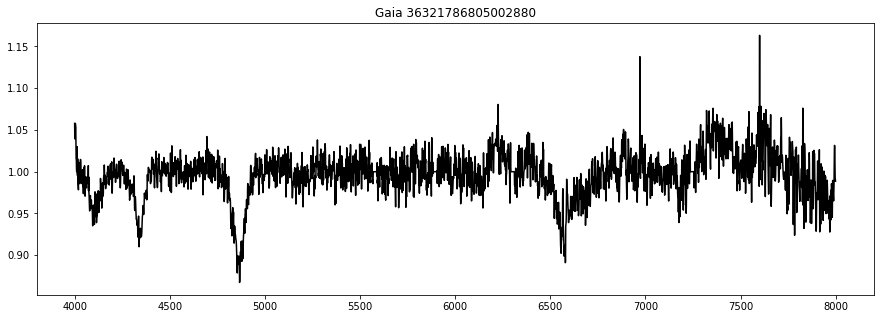

287010880318082560
Probability of Binarity = 0.96
89.94459256469986 64.21062053558005


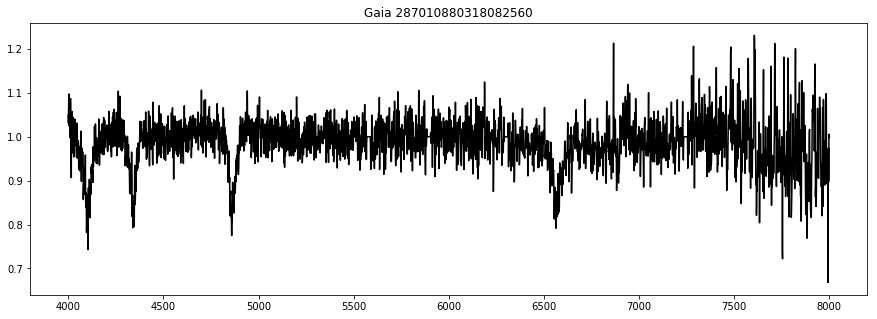

319871949978116480
Probability of Binarity = 0.94
19.837163710157103 33.830477378127824


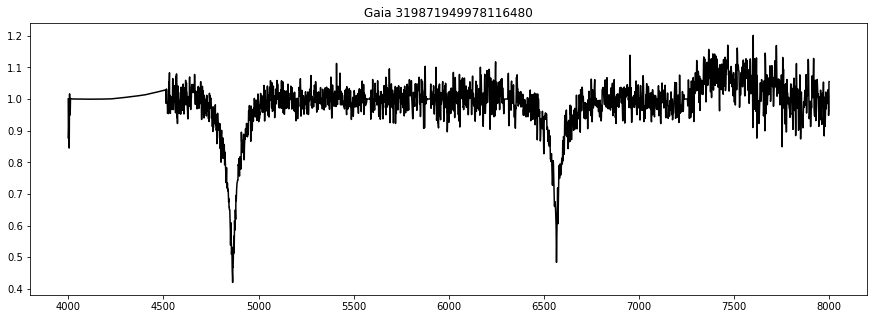

598704078692050048
Probability of Binarity = 0.97
131.49568708684586 10.391870182120902


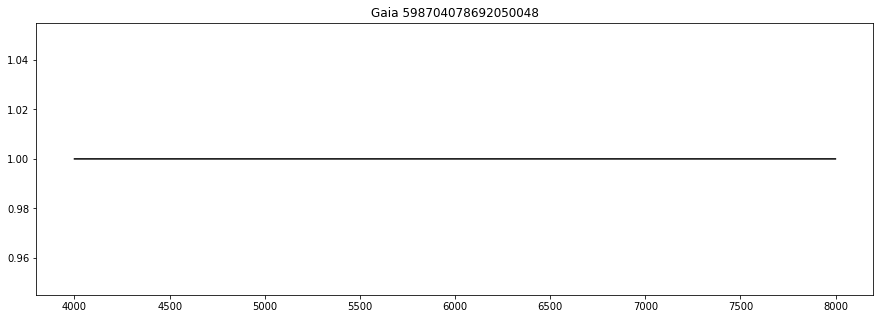

643141081646980864
Probability of Binarity = 0.92
148.23489935295927 24.81434920601817


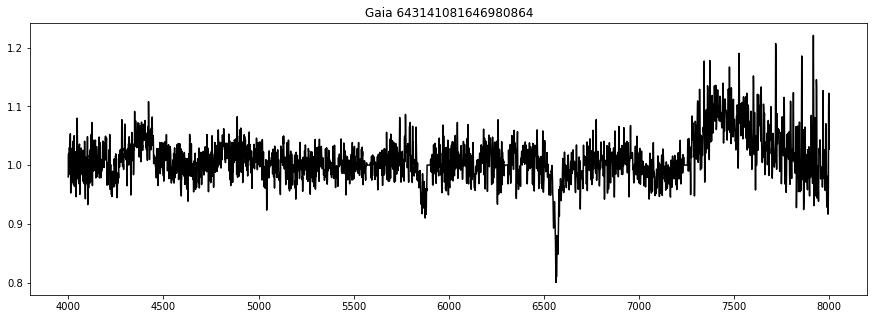

663601481211006592
Probability of Binarity = 0.92
124.9903968816701 19.8075258012476


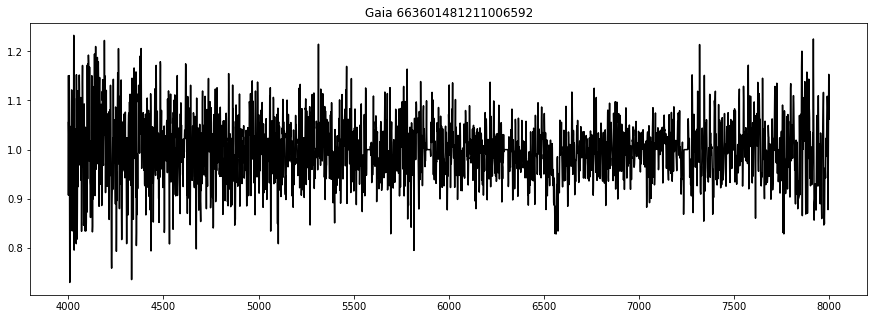

818396981642580480
Probability of Binarity = 0.93
142.59084468129342 45.352687114015275


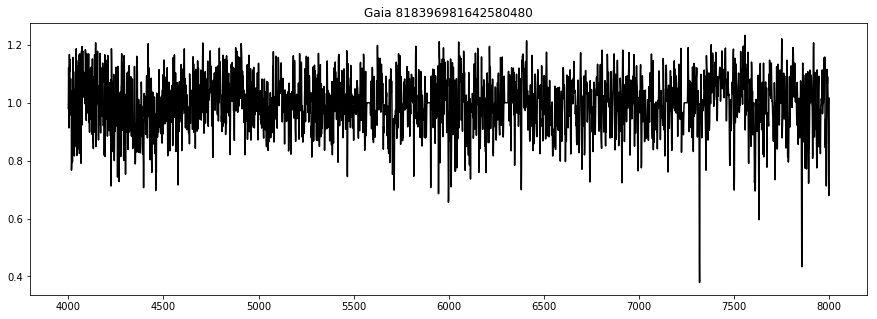

905039979674802816
Probability of Binarity = 0.97
125.45942953920819 37.239344371920645


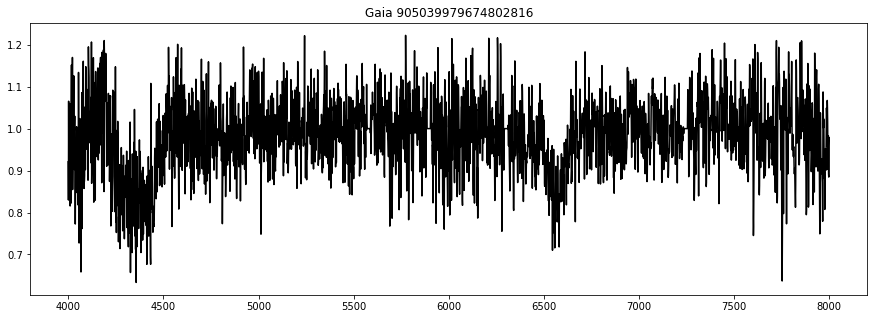

1029968414968983424
Probability of Binarity = 0.96
132.8915667053385 54.43344617019055


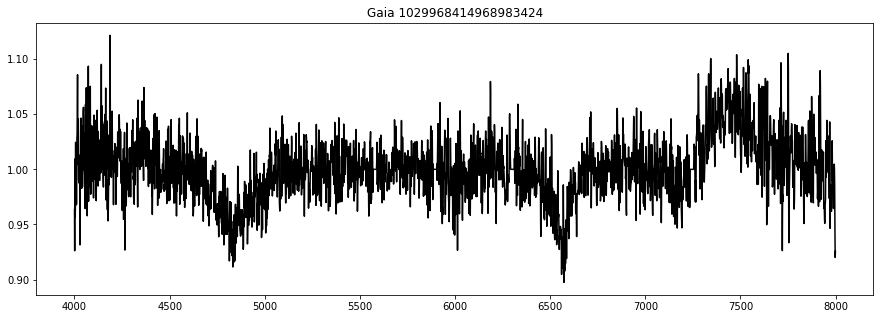

1193808772927091712
Probability of Binarity = 0.98
232.4921043235642 13.08186181974169


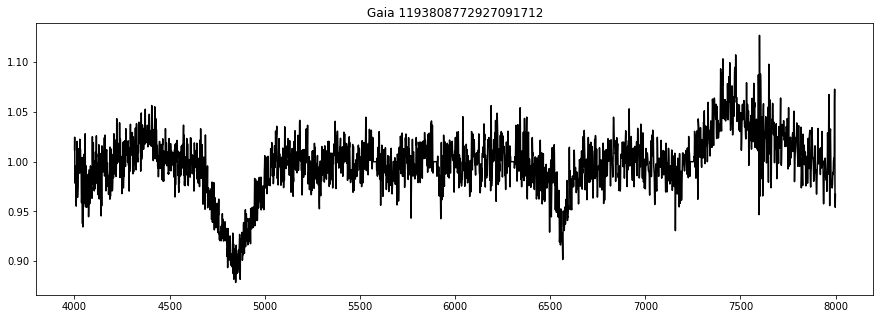

1215989182339226368
Probability of Binarity = 0.95
236.4575463208687 19.917697996744355


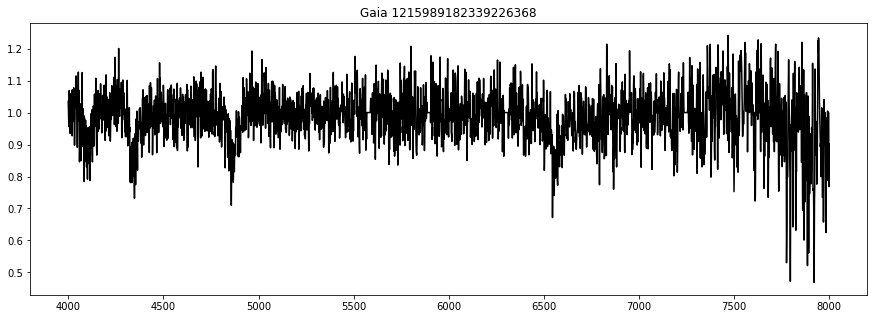

1220871426283120768
Probability of Binarity = 0.93
232.9137876389332 23.505594795791282


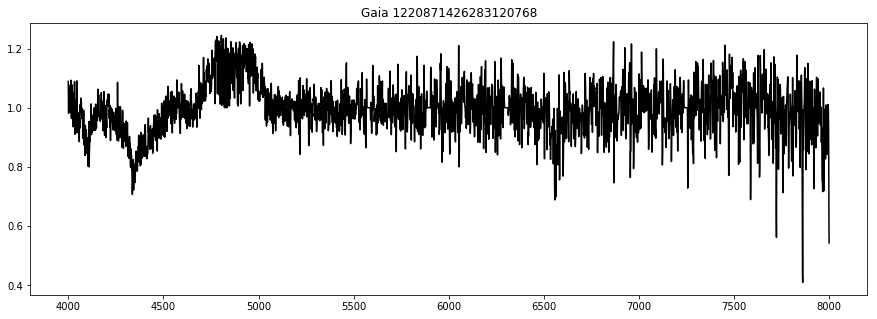

1226246251436497152
Probability of Binarity = 0.98
213.04116396040985 11.483704787027389


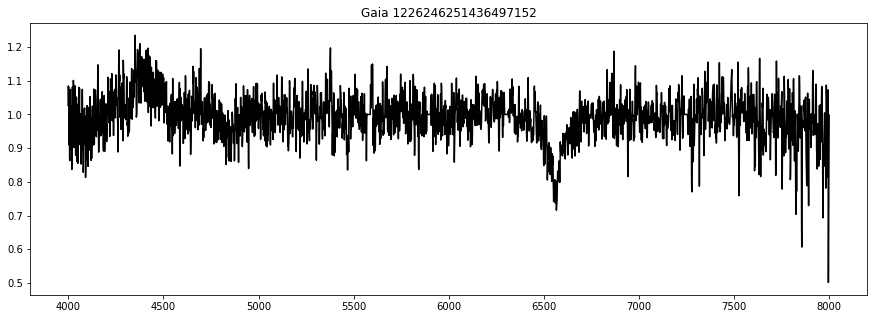

1246750944998946560
Probability of Binarity = 0.96
208.43291352159605 19.55601180416192


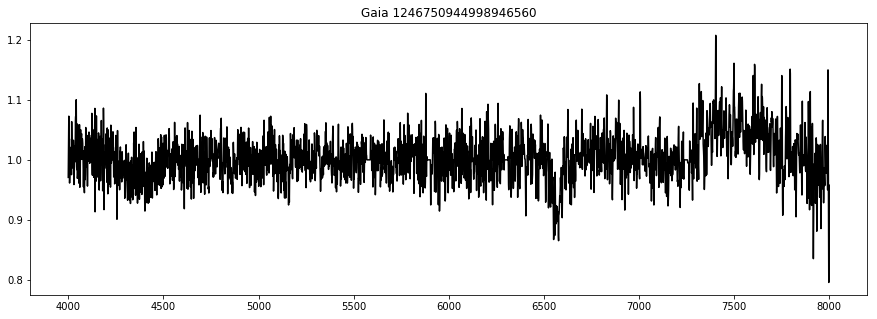

1253770497813126144
Probability of Binarity = 0.92
213.58737309608114 22.619068840799006


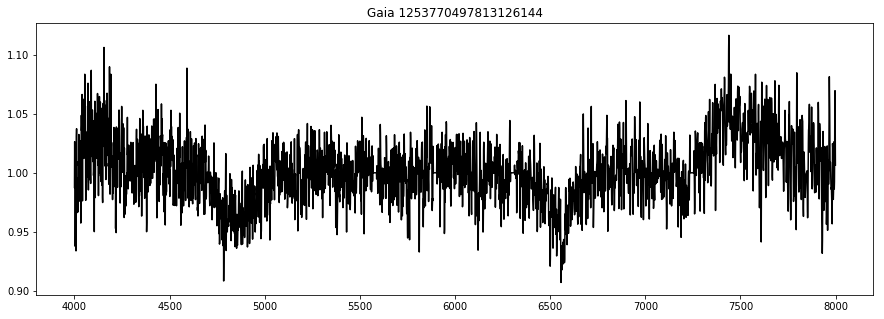

1330373339777399040
Probability of Binarity = 0.97
244.86776478549555 36.900920293637135


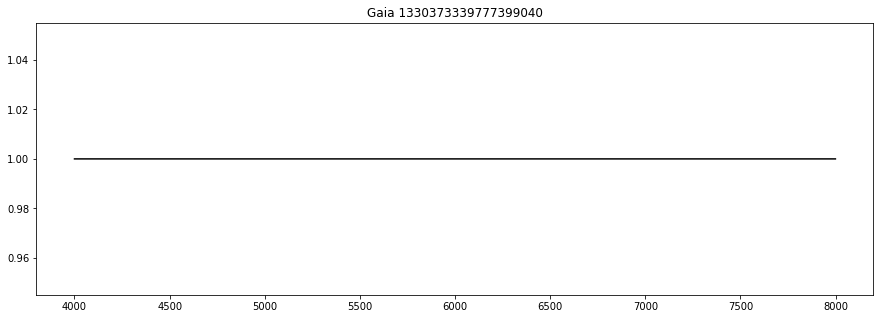

1340136036663400448
Probability of Binarity = 0.92
258.10984130814904 37.05687289896292


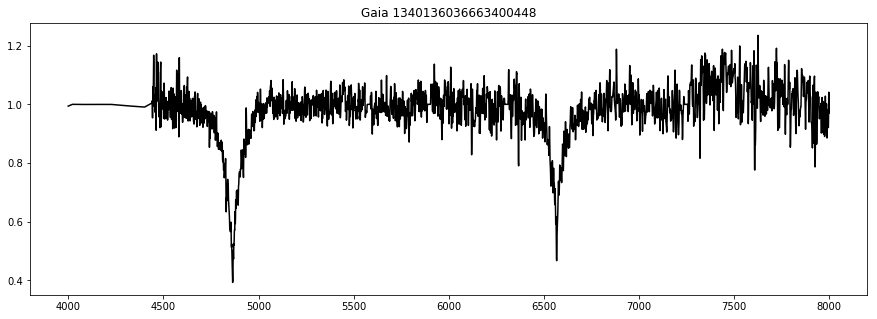

1441922814504362880
Probability of Binarity = 0.95
204.86139118266198 22.176350255138793


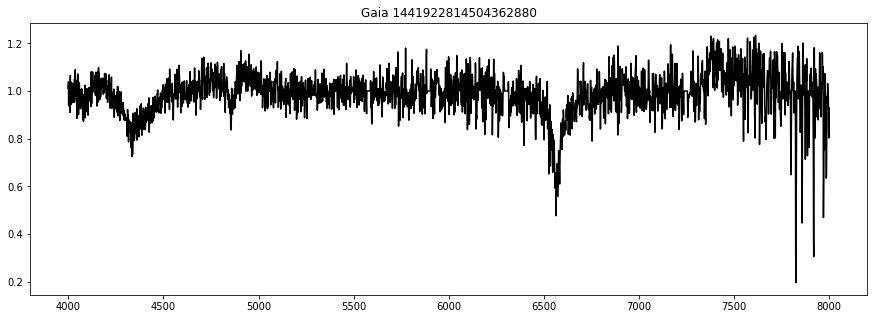

1489504004102020864
Probability of Binarity = 0.97
223.39998888136756 42.42381177280009


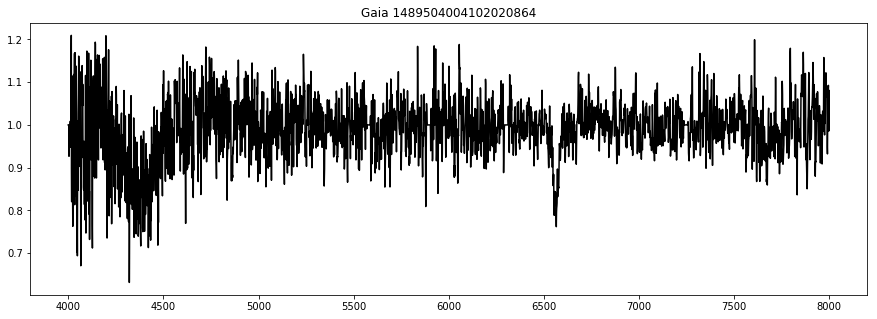

1565394671769145472
Probability of Binarity = 0.91
200.41210950225323 56.11827954756714


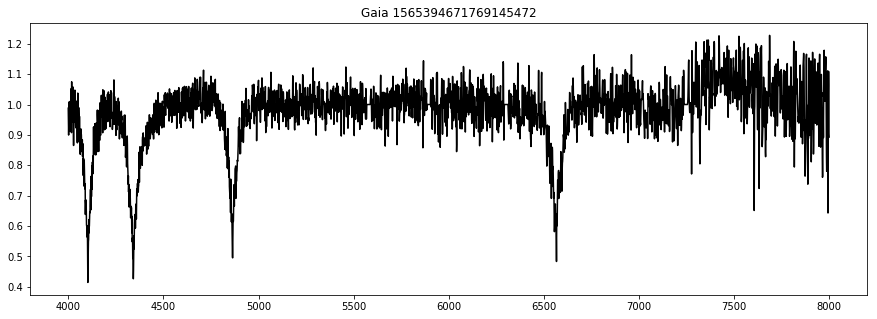

2784349060875289216
Probability of Binarity = 0.98
18.34999899511088 18.145967107318178


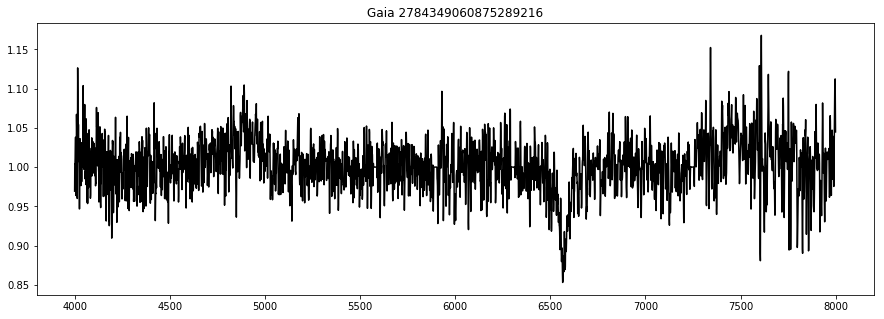

2836972408933077120
Probability of Binarity = 0.95
343.6971584125976 23.650968282809117


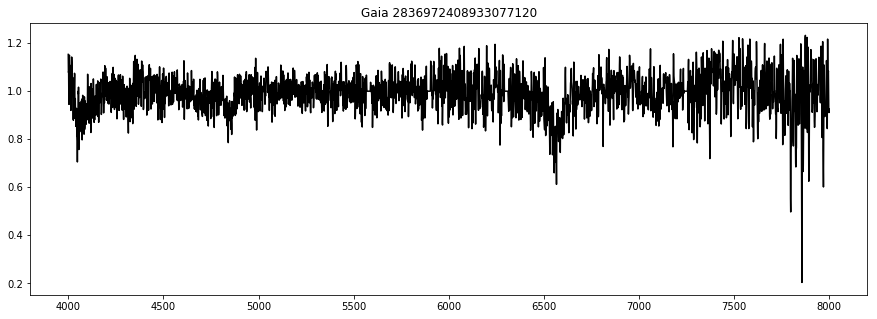

3264305235225133312
Probability of Binarity = 0.95
51.56047170091342 -0.19399984221222855


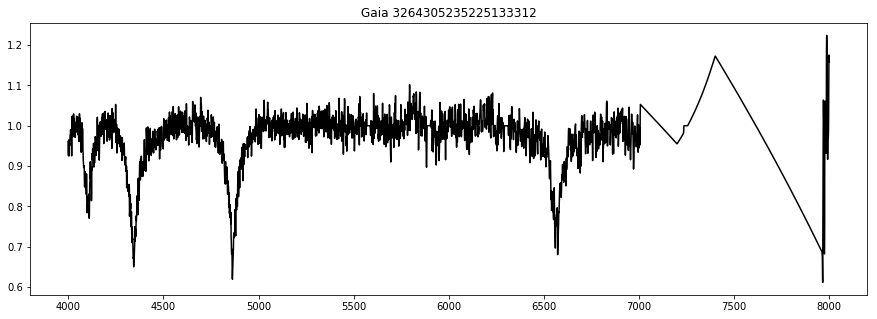

3651028381228835456
Probability of Binarity = 0.97
223.1046725384187 -0.19238441915131785


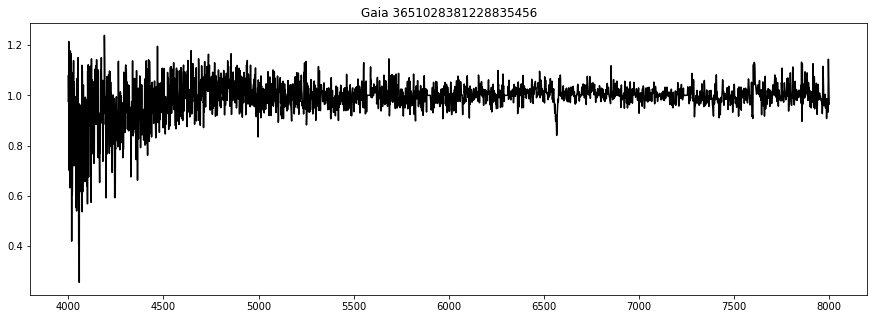

3719699342014123392
Probability of Binarity = 0.95
201.81559618041354 8.015253294364568


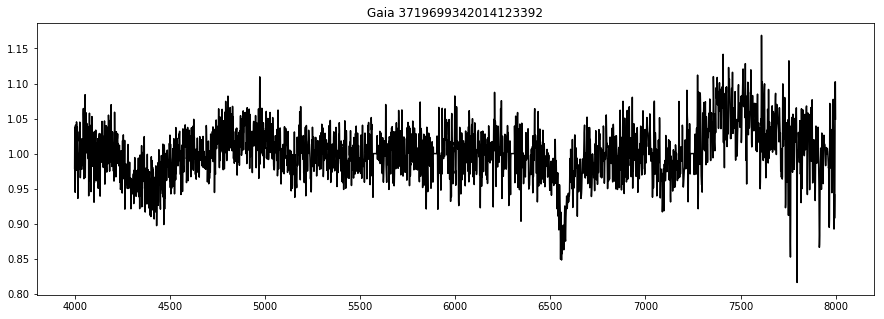

3723086662461423104
Probability of Binarity = 0.98
211.81284733339766 9.390898296170073


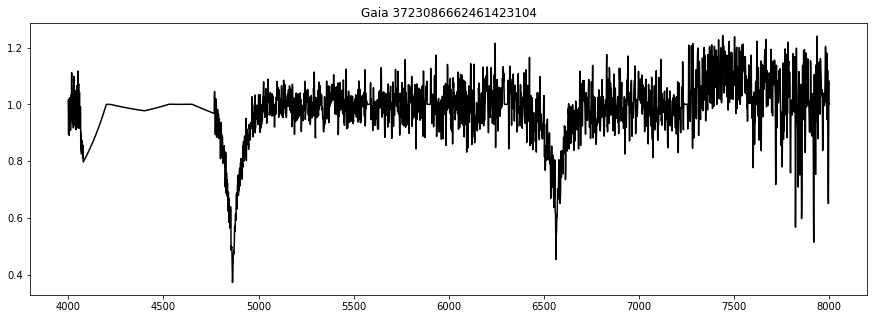

3828669018866032128
Probability of Binarity = 0.93
153.90659761533666 -3.01793922624864


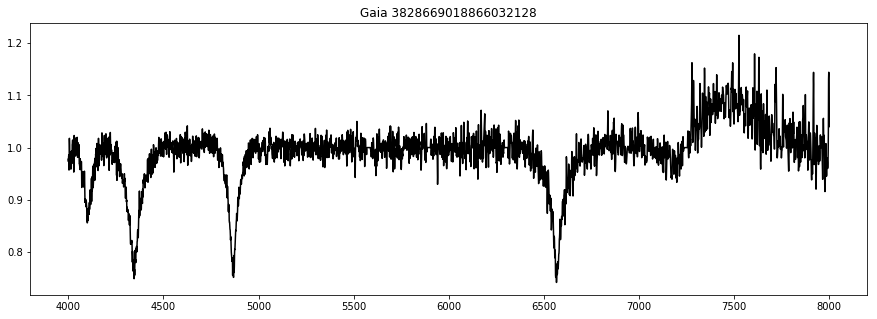

3876244577761769216
Probability of Binarity = 0.91
155.9319185385552 9.726868508534281


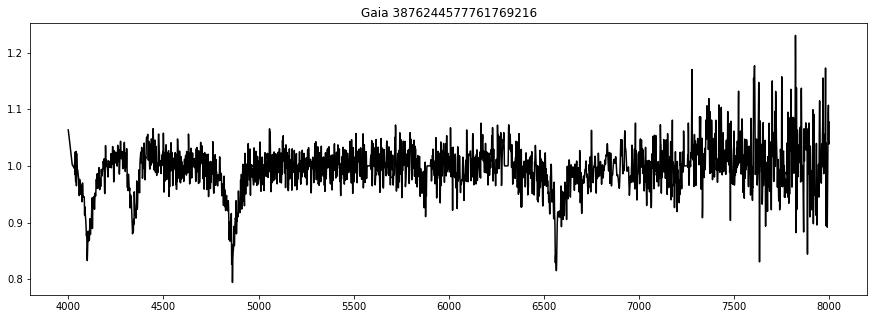

3957439461319984640
Probability of Binarity = 0.97
195.84855756010745 25.168878094577398


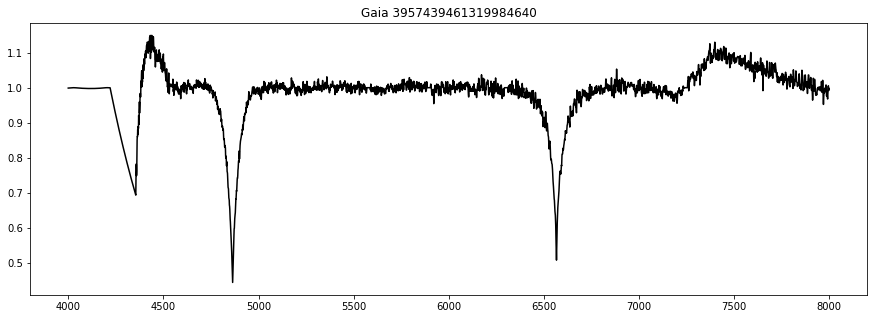

4031828157446980608
Probability of Binarity = 0.93
178.74493141929642 36.8485329369625


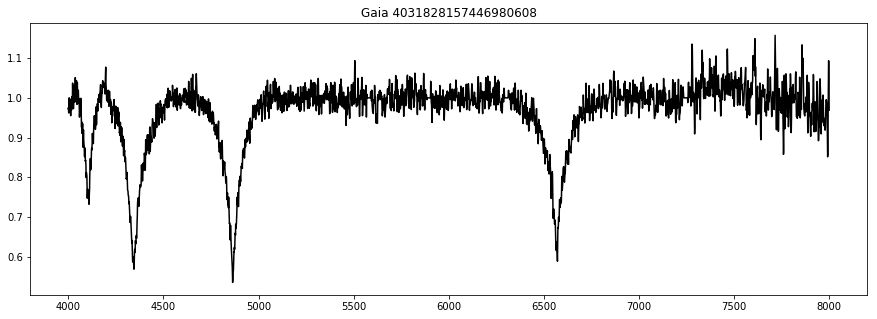

4571444515623626752
Probability of Binarity = 0.98
255.44059645154493 22.89164863774534


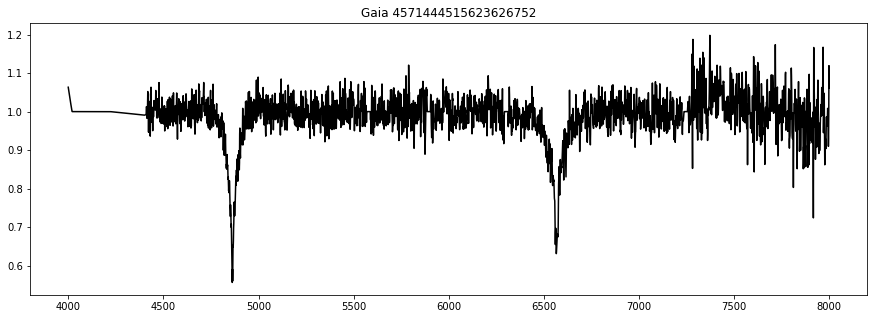

6880816957163849600
Probability of Binarity = 0.92
302.2907688364861 -11.74098157668464


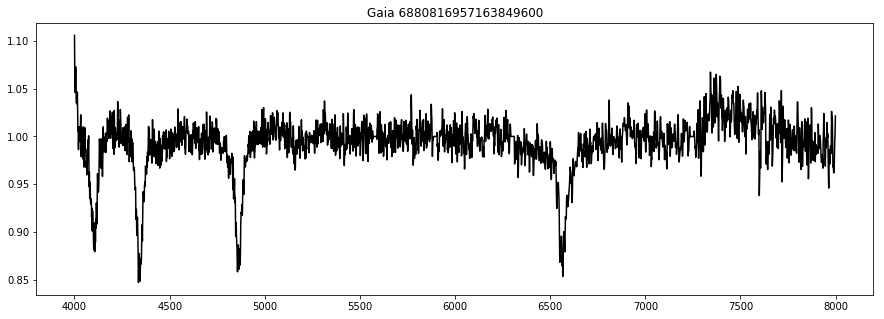

6914214103163219328
Probability of Binarity = 0.93
311.0882875697027 -5.315526671769057


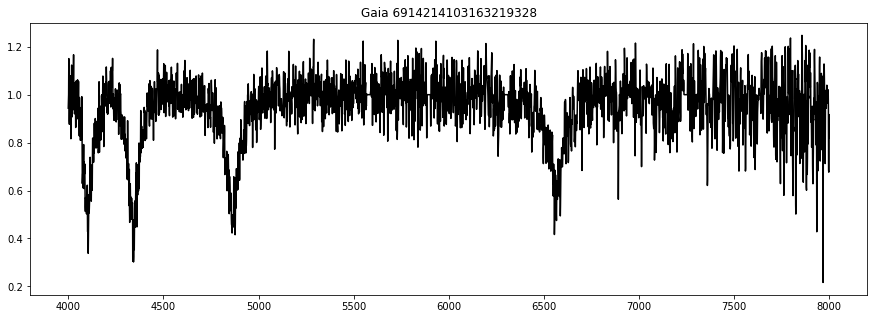

In [65]:
cont = [];
for obj in cleantable[binaries]:
    if get_spectrum(obj['source_id'])[0] == 0:
        continue
        cont.append(0)
    plt.figure(figsize = (15,5))
    plt.plot(lamgrid,get_spectrum(obj['source_id']),'k')
    plt.title('Gaia '+str(obj['source_id']))
    print(obj['source_id'])
    print('Probability of Binarity = %.2f'%obj['bin_prob'])
    plt.savefig('binary_'+str(obj['source_id'])+'png')
    print(str(obj['ra']) + ' '+str(obj['dec']))
    cont.append(1)
    plt.show()